In [6]:
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import softmax, sigmoid
from common.time_layers import *
import numpy as np

In [7]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads =[np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # RNNレイヤーの前に層が来るからdxを下流に流す
        # NLPではembedding層が来る
        return dx, dh_prev

In [8]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
       
        
    def set_state(self, h):
        self.h = h
        
        
    def reset_state(self):
        self.h = None
    
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype="f")
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype="f")
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, H), dtype="f")
        dh = 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] = grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh      
        
        return dxs

In [9]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype("f")
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype("f")
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affin_W = (rn(H, V) / np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affin_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from common.optimizer import SGD
from dataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f"{corpus_size=} {vocab_size=}")

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype="i")
        batch_t = np.empty((batch_size, time_size), dtype="i")
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    ppl = np.exp(total_loss / loss_count)
    print(f"{epoch+1}|{ppl:.2f}")
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    

corpus_size=1000 vocab_size=418
1|416.94
2|391.88
3|317.64
4|244.73
5|217.87
6|210.05
7|203.01
8|198.59
9|191.91
10|191.79
11|187.82
12|190.16
13|187.59
14|187.81
15|187.03
16|183.75
17|181.29
18|177.14
19|178.94
20|180.98
21|178.27
22|174.44
23|171.71
24|173.52
25|171.30
26|171.79
27|167.02
28|166.87
29|164.30
30|159.74
31|161.31
32|157.39
33|158.74
34|155.46
35|156.36
36|150.71
37|146.55
38|145.21
39|140.42
40|137.69
41|138.75
42|133.80
43|129.00
44|126.23
45|123.34
46|122.48
47|117.34
48|112.24
49|109.47
50|106.69
51|102.81
52|100.43
53|96.78
54|95.10
55|92.02
56|87.64
57|84.80
58|80.46
59|78.26
60|75.43
61|73.93
62|70.25
63|66.10
64|64.34
65|63.08
66|59.71
67|58.18
68|53.82
69|52.51
70|50.55
71|48.16
72|45.82
73|43.65
74|42.23
75|41.48
76|38.06
77|36.53
78|35.17
79|33.42
80|31.98
81|30.41
82|30.00
83|27.65
84|26.82
85|25.49
86|24.36
87|23.57
88|22.12
89|20.94
90|20.19
91|19.30
92|18.46
93|17.75
94|16.98
95|16.11
96|15.39
97|14.78
98|13.95
99|13.36
100|12.83


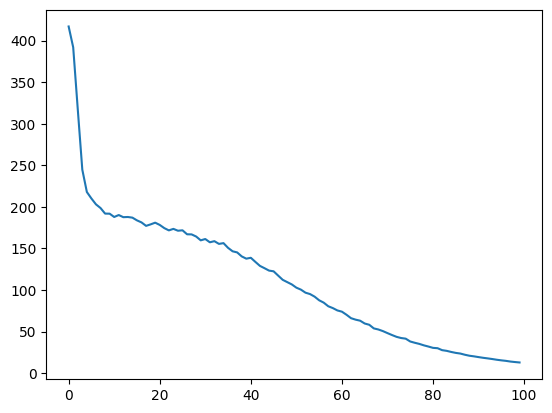

In [15]:
plt.plot(ppl_list)

In [24]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.81
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 420.06
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 400.64
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 375.08
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 330.33
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 254.86
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 224.28
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 214.79
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 205.03
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 196.22
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 196.40
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 190.60
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 192.74
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 185.87
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 184.16
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 188.33
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 186.47
| epoch 18 |  iter 1 / 

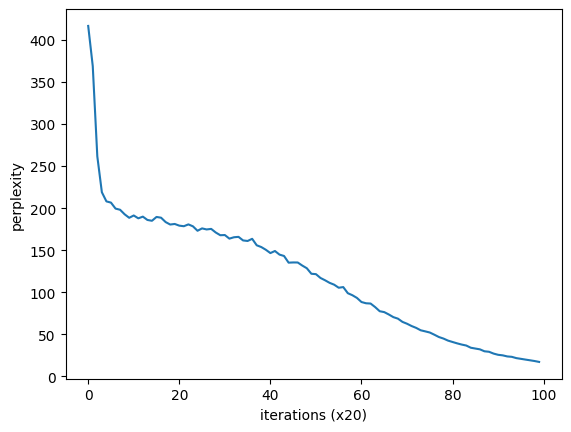

In [23]:
trainer.plot()